In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sktime.forecasting.model_selection import SlidingWindowSplitter
from joblib import Parallel, delayed
from itertools import islice
import json
import warnings
import matplotlib.pyplot as plt

In [ ]:
root_data_dir = "/projects/genomic-ml/da2343/ml_project_2/data" 
dataset_path = f"{root_data_dir}/EURUSD/EURUSD_H1_200702210000_202304242100_Update.csv"
# Load the config file
config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
with open(config_path) as f:
  config = json.load(f)
  
dataset_name = "EURUSD_H1"
# Get the take_profit and stop_loss levels from the config file
tp = config["trading_settings"][dataset_name]["take_profit"]
sl = config["trading_settings"][dataset_name]["stop_loss"]
df = pd.read_csv(dataset_path, index_col=0)

y = df[['Close']]
offset = y.index[0]

In [ ]:
df

## GENERATE SEQUENTIAL TRADE DATA

In [ ]:
def create_trade_order(row, position, tp, sl):
    ask_price = row["Close"]
    tp_price = ask_price + tp if position == 1 else ask_price - tp
    sl_price = ask_price - sl if position == 1 else ask_price + sl

    trade_order = {
        "index": row.name,
        "ask_price": ask_price,
        "take_profit_price": tp_price,
        "stop_loss_price": sl_price,
        "position": position,
        # f"SMA_{timeperiod}": row[f"SMA_{timeperiod}"],
        "MACD": row["MACD"],
        "MACD_Signal": row["MACD_Signal"],
        "MACD_Hist": row["MACD_Hist"],
        "MACD_Crossover_Change" : row["MACD_Crossover_Change"],
        "RSI": row["RSI"],
        "ATR": row["ATR"],
        "ADX": row["ADX"],
        "AROON_Oscillator": row["AROON_Oscillator"],
        "WILLR": row["WILLR"],
        "OBV": row["OBV"],
        "CCI": row["CCI"],
        "PSAR": row["PSAR"],
        "AD": row["AD"],
        "ADOSC": row["ADOSC"],
        "VOLUME_RSI": row["VOLUME_RSI"],
        "MFI": row["MFI"],
        "Date_Time": row["Date_Time"],
        "close_time": None,
        "label": None,
    }
    return trade_order


trades = []
# loop through all rows in the dataframe
for index, row in df.iterrows():
    i = index + offset

    if len(trades) != 0:
        prev_trade = trades[-1]
        # check if the previous trade was a long trade
        if prev_trade["position"] == 1:
            if row["Close"] >= prev_trade["take_profit_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 1
                prev_trade["close_time"] = row["Date_Time"]
                continue
            elif row["Close"] <= prev_trade["stop_loss_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 0
                prev_trade["close_time"] = row["Date_Time"]
                continue
        else:
            if row["Close"] <= prev_trade["take_profit_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 1
                prev_trade["close_time"] = row["Date_Time"]
                continue
            elif row["Close"] >= prev_trade["stop_loss_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 0
                prev_trade["close_time"] = row["Date_Time"]
                continue
                
        if prev_trade["label"] == None:
            continue
   
    macd_crossover_change = row["MACD_Crossover_Change"]
    if macd_crossover_change > 0 or macd_crossover_change < 0:
        current_position = 1 if macd_crossover_change > 0 else 0
        local_order = create_trade_order(row, current_position, tp, sl)
        trades.append(local_order) 

trades_df = pd.DataFrame(trades)

In [ ]:
trades_df

In [ ]:
# 2359 rows × 24 columns
# save the trades dataframe to a csv file
trades_df.to_csv(f"trades_seq_{dataset_name}_2007_2023.csv", index=False)

## GENERATE NON-SEQUENTIAL TRADE DATA

In [ ]:
##TODO: Fix this code before running it

def save_setup_graph(subset_df, position, label):
    plt.figure(figsize=(7,4))
    plt.plot(subset_df["Close"], label="Close")
    plt.plot(subset_df["SMA_20"], label="SMA_20")
    # plt.plot(df["SMA_30"], label="SMA_30")
    plt.plot(subset_df["SMA_50"], label="SMA_50")
    plt.plot(subset_df["SMA_100"], label="SMA_100")
    close_price = subset_df["Close"].iloc[-1]
    if position == 1:
        plt.axhspan(close_price, close_price + tp, facecolor="green", xmin= 0.96, alpha=0.5) 
        plt.axhspan(close_price - sl, close_price, facecolor="red", xmin= 0.96, alpha=0.5)
    else:
        plt.axhspan(close_price, close_price + sl, facecolor="red", xmin= 0.96, alpha=0.5) 
        plt.axhspan(close_price - tp, close_price, facecolor="green", xmin= 0.96, alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    save_path = f"/projects/genomic-ml/da2343/ml_project_2/data/EURUSD/{label}"
    # name should be the index of the first row in the subset_df
    plt.savefig(f"{save_path}/{subset_df.index[0]}.png", dpi=300, bbox_inches="tight")
    


trades = []
window_size = 24 * 10

# loop through all rows in the dataframe
for index in range(window_size, len(df)):
    i = index + offset

    if df.loc[i, "MACD_Crossover_Change"] > 0:
        ask_price = df.loc[i, "Close"]
        tp_price = ask_price + tp
        sl_price = ask_price - sl
        current_position = 1

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Date_Time": df.loc[i, "Date_Time"],
            "label": None,
        }
        # add a second loop to check if the current close price is greater than the take profit price
        # or less than the stop loss price
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] >= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
            elif df.loc[j, "Close"] <= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
        
        # create set-up graph for local_order
        # subset_df should be a df with window_size rows from i-window_size to i
        subset_df = df.loc[i-window_size:i]
        save_setup_graph(subset_df, current_position, local_order["label"])
        trades.append(local_order)
        
        
    elif df.loc[i, "MACD_Crossover_Change"] < 0:   
        ask_price = df.loc[i, "Close"]  
        tp_price = ask_price - tp
        sl_price = ask_price + sl
        current_position = 0

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Date_Time": df.loc[i, "Date_Time"],
            "label": None,
        }
        
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] <= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
            elif df.loc[j, "Close"] >= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
        trades.append(local_order)
        
trades_df = pd.DataFrame(trades)

In [ ]:
trades_df

In [ ]:
# 2359 rows × 24 columns
# save the trades dataframe to a csv file
trades_df.to_csv(f"trades_non_seq_{dataset_name}_2011_2023.csv", index=False)

In [ ]:
# get outcomes from trades_df using the label column
outcomes = trades_df["label"].tolist()

accuracy_df = pd.DataFrame({
    'accuracy': accuracy_score([1] * len(outcomes), outcomes),
    'no_of_trades': len(outcomes),
    'no_of_wins': sum(outcomes),
    'no_of_losses': len(outcomes) - sum(outcomes),
}, index=[0])

## Generate Trade Data Script

In [4]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sktime.forecasting.model_selection import SlidingWindowSplitter
from joblib import Parallel, delayed
from itertools import islice
import json
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime as dt
import requests
import sys
import re
import itertools
import os
import talib
import logging
from decimal import Decimal
import io
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image


dataset_name = "AUD_CAD_H1"
# root_data_dir = "/projects/genomic-ml/da2343/ml_project_2/data/USDJPY" 
root_data_dir = "/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data" 
dataset_path = f"{root_data_dir}/{dataset_name}_processed_data.csv"


# Load the config file
config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
# config_path = "/Users/newuser/Projects/robust-algo-trader/settings/config.json"
with open(config_path) as f:
  config = json.load(f)  
# Get the take_profit and stop_loss levels from the config file
config_settings = config["trading_settings"][dataset_name]
window_size = config["window_size"]
tp = config_settings["take_profit"]
sl = config_settings["stop_loss"]

df = pd.read_csv(dataset_path)
df = df.rename(columns={'time': 'Time'})

# filter only up to 2013
df = df[df['Time'] < '2013-01-01 00:00:00']

df['Index'] = df.index
y = df[['Close']]
offset = y.index[0]

In [5]:
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,STOCH_D,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index
0,2005-01-03 09:00:00+00:00,0.93783,0.93959,0.93625,0.93756,856,0.939397,0.940370,0.935346,0.926007,...,62.846414,-58.498706,0.938738,0.937776,0.936814,-1196.877489,-328.921643,66.156627,37.103206,0
1,2005-01-03 10:00:00+00:00,0.93739,0.93906,0.93704,0.93853,475,0.938921,0.940525,0.935476,0.926278,...,61.044829,-37.378115,0.938563,0.937740,0.936917,-971.134915,-257.875562,53.432428,41.634078,1
2,2005-01-03 11:00:00+00:00,0.93888,0.93976,0.93774,0.93783,518,0.938974,0.940544,0.935622,0.926574,...,58.472392,-44.962080,0.938591,0.937810,0.937029,-1442.976499,-355.499436,54.496162,45.929356,2
3,2005-01-03 12:00:00+00:00,0.93774,0.94056,0.93629,0.93840,883,0.938923,0.940573,0.935754,0.926830,...,56.613143,-38.786566,0.938776,0.938012,0.937248,-1453.316077,-366.408210,62.356613,39.943983,3
4,2005-01-03 13:00:00+00:00,0.93848,0.94304,0.93804,0.94065,1785,0.939023,0.940629,0.935971,0.927124,...,55.308202,-23.226433,0.940771,0.938594,0.936417,-1374.776077,-312.571054,74.211995,49.070828,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52202,2012-12-31 14:00:00+00:00,1.03313,1.03408,1.03291,1.03335,1906,1.033236,1.033277,1.032757,1.031863,...,41.742019,-49.774775,1.033867,1.032450,1.031033,579208.986861,-200.580836,58.023384,63.331441,52202
52203,2012-12-31 15:00:00+00:00,1.03339,1.03456,1.03317,1.03379,2572,1.033230,1.033289,1.032843,1.031868,...,59.148263,-31.887755,1.034492,1.032712,1.030932,578931.432904,-267.486251,63.127674,67.270524,52203
52204,2012-12-31 16:00:00+00:00,1.03378,1.03612,1.03356,1.03490,2451,1.033296,1.033339,1.032926,1.031887,...,70.993343,-24.400000,1.035407,1.033384,1.031361,579046.323529,-233.983608,61.660668,74.735716,52204
52205,2012-12-31 17:00:00+00:00,1.03491,1.03504,1.03020,1.03306,3081,1.033286,1.033318,1.032982,1.031885,...,73.004702,-51.689189,1.035003,1.033640,1.032277,579606.505347,-20.767075,66.080461,62.405673,52205


In [ ]:
# Set a random seed for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# Define data transformations
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
device = "cpu"
PATH = f"{BASE_DIR}/ml_models/model_39.pth"
# Define the model
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 5) 
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(86528, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply the convolutional layers with pooling and dropout
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x
# Load the trained model
cnn = CNNet()
cnn.load_state_dict(torch.load(PATH))
cnn.to(device)
cnn.eval()

In [ ]:

def save_setup_graph(subset_df, position, label, index):
    green_df = subset_df[subset_df['Close'] > subset_df['Open']].copy()
    green_df["Height"] = green_df["Close"] - green_df["Open"]
    red_df = subset_df[subset_df['Close'] < subset_df['Open']].copy()
    red_df["Height"] = red_df["Open"] - red_df["Close"]
    
    # switch to "Agg" backend to prevent showing
    plt.switch_backend("Agg")
    fig = plt.figure(figsize=(8, 3))
    
    ##Grey Lines
    plt.vlines(x=green_df["Index"], 
            ymin=green_df["Low"], 
            ymax=green_df["High"],
            color="green")
    plt.vlines(x=red_df["Index"], 
            ymin=red_df["Low"], 
            ymax=red_df["High"],
            color="orangered")
    ##Green Candles
    plt.bar(x=green_df["Index"], 
            height=green_df["Height"], 
            bottom=green_df["Open"], 
            color="green")
    ##Red Candles
    plt.bar(x=red_df["Index"], 
            height=red_df["Height"], 
            bottom=red_df["Close"], 
            color="orangered")
    
    plt.plot(subset_df["SMA_20"], label="SMA_20")
    plt.plot(subset_df["SMA_30"], label="SMA_30")
    
    close_price = subset_df["Close"].iloc[-1]
    sl_eps = sl
    tp_eps = tp
    
    if position == 1:
        plt.axhspan(close_price, close_price + tp_eps, facecolor="green", xmin= 0.96, alpha=0.9) 
        plt.axhspan(close_price - sl_eps, close_price, facecolor="orangered", xmin= 0.96, alpha=0.9)
    else:
        plt.axhspan(close_price, close_price + sl_eps, facecolor="orangered", xmin= 0.96, alpha=0.9) 
        plt.axhspan(close_price - tp_eps, close_price, facecolor="green", xmin= 0.96, alpha=0.9)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    
    
    buf = io.BytesIO()
    plt.savefig(buf, dpi=128, bbox_inches="tight", format="png")
    buf.seek(0)
    image = Image.open(buf).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    # Get the model output
    output = cnn(image)
    output_item = output.item()
    buf.close()
    
    pred_label = 1 if output_item > 0.5 else 0:
    if pred_label == label:
        # name should be the index of the first row in the subset_df
        # Check if the directory exists, if not, create it
        directory_path = f"{root_data_dir}/{dataset_name}/{label}"
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
        plt.savefig(f"{directory_path}/{index}.png", dpi=128, bbox_inches="tight")
    # close the figure
    plt.close()
    

trades = []

# loop through all rows in the dataframe
for index in range(window_size, len(df)):
    i = index + offset

    if df.loc[i, "MACD_Crossover_Change"] > 0:
        ask_price = df.loc[i, "Close"]
        tp_price = ask_price + tp
        sl_price = ask_price - sl
        current_position = 1

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Time": df.loc[i, "Time"],
            "label": None,
        }
        # add a second loop to check if the current close price is greater than the take profit price
        # or less than the stop loss price
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] >= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Time"]
                break
            elif df.loc[j, "Close"] <= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Time"]
                break
        
        if local_order["label"] is None:
            break    
        # create set-up graph for local_order
        # subset_df should be a df with window_size rows from i-window_size to i
        subset_df = df.loc[i-window_size:i]
        save_setup_graph(subset_df, current_position, local_order["label"], i)
        trades.append(local_order)
    elif df.loc[i, "MACD_Crossover_Change"] < 0:   
        ask_price = df.loc[i, "Close"]  
        tp_price = ask_price - tp
        sl_price = ask_price + sl
        current_position = 0

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Time": df.loc[i, "Time"],
            "label": None,
        }
        
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] <= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Time"]
                break
            elif df.loc[j, "Close"] >= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Time"]
                break
        
        if local_order["label"] is None:
            break
        subset_df = df.loc[i-window_size:i]
        save_setup_graph(subset_df, current_position, local_order["label"], i)
        trades.append(local_order)
        
# trades_df = pd.DataFrame(trades)
print("Done!")


# Generate Synthetic OHLCV Data

/var/folders/jf/1lv8wgr503396_w00202kgmw0000gp/T/ipykernel_41842/3311659439.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_data['Close'].iloc[-1] = prices[-1] + 0.5 * np.random.random()  # Fill the last Close price with a random value


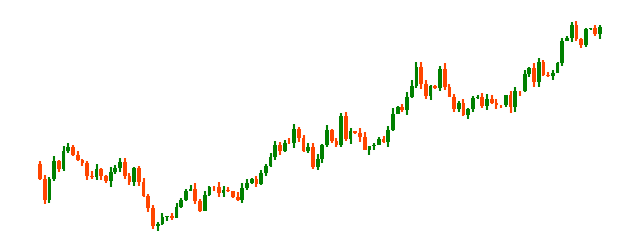

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_ohlc_data(num_records=100, start_date='2022-01-01', freq='D', initial_price=100.0):
    # np.random.seed(42)  # Set seed for reproducibility
    
    # Generate date range
    date_rng = pd.date_range(start=start_date, periods=num_records, freq=freq)
    
    # Generate initial price and random price changes
    prices = initial_price + np.cumsum(np.random.normal(0, 1, num_records))
    
    # Generate OHLCV data
    ohlcv_data = pd.DataFrame(index=date_rng, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    ohlcv_data['Open'] = prices - 0.5 * np.random.random(num_records)
    ohlcv_data['Close'] = np.roll(ohlcv_data['Open'], -1)  # Shift the Open prices by one position to the left
    ohlcv_data['Close'].iloc[-1] = prices[-1] + 0.5 * np.random.random()  # Fill the last Close price with a random value
    ohlcv_data['High'] = ohlcv_data[['Open', 'Close']].max(axis=1) + 0.5 * np.random.random(num_records)
    ohlcv_data['Low'] = ohlcv_data[['Open', 'Close']].min(axis=1) - 0.5 * np.random.random(num_records)
    ohlcv_data['Volume'] = np.random.randint(100, 1000, size=num_records)
    
    return ohlcv_data

# Generate synthetic OHLCV data
ohlc_data = generate_ohlc_data(num_records=365, start_date='2022-01-01').copy()



df = ohlc_data
# add new Index column
df['Index'] = df.index
df

# First 30 rows
# df = df.head(24 * 5)

df = df.head(24*5)

green_df = df[df['Close'] > df['Open']].copy()
green_df["Height"] = green_df["Close"] - green_df["Open"]
red_df = df[df['Close'] < df['Open']].copy()
red_df["Height"] = red_df["Open"] - red_df["Close"]


fig = plt.figure(figsize=(8,3))

##Grey Lines
plt.vlines(x=green_df["Index"], 
           ymin=green_df["Low"], 
           ymax=green_df["High"],
           color="green")
plt.vlines(x=red_df["Index"], 
           ymin=red_df["Low"], 
           ymax=red_df["High"],
           color="orangered")

##Green Candles
plt.bar(x=green_df["Index"], 
        height=green_df["Height"], 
        bottom=green_df["Open"], 
        color="green")
##Red Candles
plt.bar(x=red_df["Index"], 
        height=red_df["Height"], 
        bottom=red_df["Close"], 
        color="orangered")

# plt.plot(df["SMA_20"], label="SMA_20")
# plt.plot(df["SMA_30"], label="SMA_30")
# plt.plot(df["SMA_50"], label="SMA_50")
# plt.plot(df["SMA_100"], label="SMA_100")

close_price = df["Close"].iloc[-1] # Get the close price of the last row

delta = 0.0025
plt.axhspan(close_price, close_price + delta, facecolor="orangered", xmin= 0.96,  alpha=0.9) 
plt.axhspan(close_price - delta, close_price, facecolor="green", xmin= 0.96,  alpha=0.9) 

plt.xticks([])
plt.yticks([])
plt.box(False)

# plt.savefig('plot.png', dpi=128, bbox_inches='tight')
# Show the plot
plt.show()
